# Model Run
Version 1: linear  
Version 2: CNN (Sound directly)  
Version 3: CNN (Mel)  
Version 3.1: CNN (Mel) Modifications  
Version 6.1: formal run of original, full data

## Import Libs

In [27]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, random_split
import torchaudio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from torchinfo import summary
import torch.nn.functional as F
from torch.nn import init


from model_model import SelfPackLSTM
from model_configs import ModelDimConfigs, TrainingConfigs
from misc_tools import get_timestamp
from model_dataset import DS_Tools, Padder, TokenMap, NormalizerKeepShape
from model_dataset import SingleRecSelectBalanceDatasetPrecombine as ThisDataset
from model_filter import XpassFilter
from paths import *
from ssd_paths import *
from misc_progress_bar import draw_progress_bar
from misc_recorder import *

## Configure READ

In [28]:
READ = False

## Get Timestamp

In [29]:
if READ: 
    ts = ""
else: 
    ts = str(get_timestamp())
    # ts = "1211210544"

train_name = "0_RUN"
model_save_dir = os.path.join(model_save_, f"{train_name}-{ts}")
print(f"{train_name}-{ts}")
mk(model_save_dir)

0_RUN-1211213240


In [30]:
stop_epoch = "149"
save_trainhist_name = "train.hst"
save_valhist_name = "val.hst"
save_valacc_name = "valacc.hst"
save_trainacc_name = "trainacc.hst"

## Prepare Loss Recording

In [31]:
train_losses = ListRecorder(os.path.join(model_save_dir, save_trainhist_name))
valid_losses = ListRecorder(os.path.join(model_save_dir, save_valhist_name))

valid_accs = ListRecorder(os.path.join(model_save_dir, save_valacc_name))
train_accs = ListRecorder(os.path.join(model_save_dir, save_trainacc_name))

## Prepare Dataset

In [32]:
mytrans = nn.Sequential(
    Padder(sample_rate=TrainingConfigs.REC_SAMPLE_RATE, pad_len_ms=250, noise_level=1e-4), 
    torchaudio.transforms.MelSpectrogram(TrainingConfigs.REC_SAMPLE_RATE, 
                                         n_mels=TrainingConfigs.N_MELS, 
                                         n_fft=TrainingConfigs.N_FFT, 
                                         power=2), 
    torchaudio.transforms.AmplitudeToDB(stype="power", top_db=80), 
    NormalizerKeepShape(NormalizerKeepShape.norm_mvn)
)

with open(os.path.join(src_, "no-stress-seg.dict"), "rb") as file:
    # Load the object from the file
    mylist = pickle.load(file)

mylist.remove('AH') # we don't include this, it is too mixed. 
select = mylist

# Now you can use the loaded object
mymap = TokenMap(mylist)
train_ds = ThisDataset(strain_cut_audio_, 
                       os.path.join(suse_, "guide_train.csv"), 
                       select=select, 
                       mapper=mymap, 
                       transform=mytrans)
valid_ds = ThisDataset(strain_cut_audio_, 
                       os.path.join(suse_, "guide_validation.csv"), 
                       select=select, 
                       mapper=mymap,
                       transform=mytrans)
use_proportion = 0.01

if not READ: 
    # train data
    use_len = int(use_proportion * len(train_ds))
    remain_len = len(train_ds) - use_len
    use_train_ds, remain_ds = random_split(train_ds, [use_len, remain_len])

    # valid data
    use_len = int(use_proportion * len(valid_ds))
    remain_len = len(valid_ds) - use_len
    use_valid_ds, remain_ds = random_split(valid_ds, [use_len, remain_len])

    # NOTE: we don't need to save the cut-small subset, because after cutting-small, 
    # the saved train and valid separations will reflect this
    DS_Tools.save_indices(os.path.join(model_save_dir, "train.use"), use_train_ds.indices)
    DS_Tools.save_indices(os.path.join(model_save_dir, "valid.use"), use_valid_ds.indices)
else: 
    train_ds_indices = DS_Tools.read_indices(os.path.join(model_save_dir, "train.use"))
    valid_ds_indices = DS_Tools.read_indices(os.path.join(model_save_dir, "valid.use"))

    use_train_ds = torch.utils.data.Subset(train_ds, train_ds_indices)
    use_valid_ds = torch.utils.data.Subset(valid_ds, valid_ds_indices)

train_loader = DataLoader(use_train_ds, batch_size=TrainingConfigs.BATCH_SIZE, 
                          shuffle=True, 
                          num_workers=TrainingConfigs.LOADER_WORKER)
train_num = len(train_loader.dataset)

valid_loader = DataLoader(use_valid_ds, batch_size=TrainingConfigs.BATCH_SIZE, 
                          shuffle=False, 
                          num_workers=TrainingConfigs.LOADER_WORKER)
valid_num = len(valid_loader.dataset)

In [33]:
train_num, valid_num, mymap.token_num()

(24921, 3218, 38)

In [34]:
# Load sample data from train_loader
sample_data = next(iter(valid_loader))
xx_pad, seg = sample_data

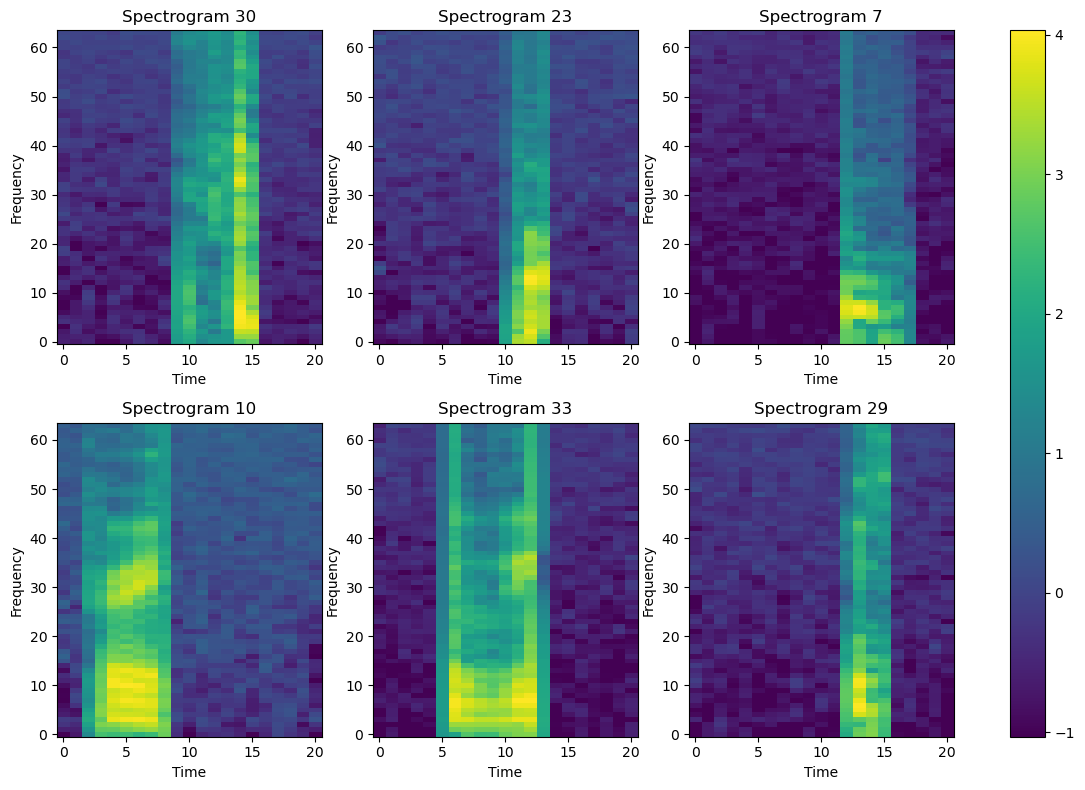

In [35]:
# Set the random seed for reproducibility
# random.seed(101)
# Generate six random indices
random_indices = random.sample(range(len(xx_pad)), 6)

# Plot the spectrograms and mark the corresponding seg
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

for i, idx in enumerate(random_indices):
    spectrogram = xx_pad[idx]
    segment = seg[idx]
    
    ax = axes[i]
    img = ax.imshow(spectrogram[0], aspect='auto', origin="lower")
    # ax.axvline(x=segment, color='red', linestyle='--')
    # ax.axvline(x=segment[1], color='red', linestyle='--')
    ax.set_title(f'Spectrogram {segment}')
    ax.set_xlabel('Time')
    ax.set_ylabel('Frequency')
plt.tight_layout()
plt.colorbar(img,ax=axes)
plt.show()

## Init Model

In [36]:
# class JudgeNetwork(nn.Module):
#     def __init__(self, dimconf:ModelDimConfigs):
#         super().__init__()
#         conv_layers = []

#         self.conv1 = nn.Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
#         self.relu1 = nn.ReLU()
#         self.bn1 = nn.BatchNorm2d(8)
#         init.kaiming_normal_(self.conv1.weight, a=0.1)
#         self.conv1.bias.data.zero_()
#         conv_layers += [self.conv1, self.relu1, self.bn1]

#         # Adjust the other convolutional blocks accordingly

#         self.conv2 = nn.Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
#         self.relu2 = nn.ReLU()
#         self.bn2 = nn.BatchNorm2d(16)
#         init.kaiming_normal_(self.conv2.weight, a=0.1)
#         self.conv2.bias.data.zero_()
#         conv_layers += [self.conv2, self.relu2, self.bn2]

#         # Adjust the other convolutional blocks accordingly

#         self.conv3 = nn.Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
#         self.relu3 = nn.ReLU()
#         self.bn3 = nn.BatchNorm2d(32)
#         init.kaiming_normal_(self.conv3.weight, a=0.1)
#         self.conv3.bias.data.zero_()
#         conv_layers += [self.conv3, self.relu3, self.bn3]

#         self.conv4 = nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
#         self.relu4 = nn.ReLU()
#         self.bn4 = nn.BatchNorm2d(64)
#         init.kaiming_normal_(self.conv4.weight, a=0.1)
#         self.conv4.bias.data.zero_()
#         conv_layers += [self.conv4, self.relu4, self.bn4]

#         self.ap = nn.AdaptiveAvgPool2d(output_size=1)
#         self.lin = nn.Linear(in_features=64, out_features=39)

#         self.conv = nn.Sequential(*conv_layers)

#     def forward(self, x):
#         x = self.conv(x)
#         x = self.ap(x)
#         x = x.view(x.shape[0], -1)
#         x = self.lin(x)
#         return x

#     def predict_on_output(self, output): 
#         output = nn.Softmax(dim=1)(output)
#         preds = torch.argmax(output, dim=1)
#         return preds

In [37]:
# ti = torch.rand((16, 1, 64, 21))
#             nn.Conv2d(64, 256, kernel_size=(3, 3), stride=1), 
#             nn.ReLU(), 
#             nn.BatchNorm2d(256), 
#             nn.MaxPool2d(kernel_size=2),  

In [38]:
# nn.Sequential(
#             nn.Conv2d(1, 16, kernel_size=7, stride=1, padding=3), 
#             nn.ReLU(), 
#             nn.BatchNorm2d(16), 
#             nn.MaxPool2d(kernel_size=2, stride=2), 
#             nn.Conv2d(16, 64, kernel_size=5, stride=1, padding=2), 
#             nn.ReLU(), 
#             nn.BatchNorm2d(64), 
#             nn.MaxPool2d(kernel_size=2, stride=2), 
#             nn.Conv2d(64, 256, kernel_size=3, stride=1, padding=1), 
#             nn.ReLU(), 
#             nn.BatchNorm2d(256), 
#             nn.MaxPool2d(kernel_size=2, stride=2)
#         )(ti).shape

In [39]:
summary(nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(16), 
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2, stride=2), 
            nn.Conv2d(16, 64, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(64), 
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2, stride=2), 
            nn.Conv2d(64, 256, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(256), 
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2, stride=2)
        ), input_size=(128, 1, 64, 21))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [128, 256, 8, 2]          --
├─Conv2d: 1-1                            [128, 16, 64, 21]         160
├─BatchNorm2d: 1-2                       [128, 16, 64, 21]         32
├─ReLU: 1-3                              [128, 16, 64, 21]         --
├─MaxPool2d: 1-4                         [128, 16, 32, 10]         --
├─Conv2d: 1-5                            [128, 64, 32, 10]         9,280
├─BatchNorm2d: 1-6                       [128, 64, 32, 10]         128
├─ReLU: 1-7                              [128, 64, 32, 10]         --
├─MaxPool2d: 1-8                         [128, 64, 16, 5]          --
├─Conv2d: 1-9                            [128, 256, 16, 5]         147,712
├─BatchNorm2d: 1-10                      [128, 256, 16, 5]         512
├─ReLU: 1-11                             [128, 256, 16, 5]         --
├─MaxPool2d: 1-12                        [128, 256, 8, 2]          --
Tota

In [50]:
class JudgeNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(16), 
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2, stride=2), 
            nn.Conv2d(16, 64, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(64), 
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2, stride=2), 
            nn.Conv2d(64, 256, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(256), 
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.ap = nn.AdaptiveAvgPool2d(output_size=1)
        self.lin_1 = nn.Sequential(
            nn.Linear(256 * 8 * 2, 512), 
            nn.Dropout(0.7), 
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 256),
        )
        self.lin = nn.Linear(in_features=256, out_features=len(select))

        self.conv.apply(self.init_conv_weights)
        self.lin.apply(self.init_lin_weights)

    def init_lin_weights(self, m):
        if isinstance(m, nn.Linear):
            # torch.nn.init.xavier_normal_(m.weight)
            torch.nn.init.kaiming_normal_(m.weight, a=0.1)
            m.bias.data.fill_(0.01)
    
    def init_conv_weights(self, m):
        if isinstance(m, nn.Conv2d):
            torch.nn.init.kaiming_normal_(m.weight, a=0.1)
            m.bias.data.zero_()

    def forward(self, x):
        x = self.conv(x)
        # x = self.ap(x)
        # x = x.view(x.shape[0], -1)
        x = x.view(x.shape[0], -1)
        x = self.lin_1(x)
        x = self.lin(x)
        return x

    def predict_on_output(self, output): 
        output = nn.Softmax(dim=1)(output)
        preds = torch.argmax(output, dim=1)
        return preds

In [51]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()
# NOTE: no need to mask the loss, because we don't do reconstruction. 

# dimconf = ModelDimConfigs(
#         rnn_in_size=TrainingConfigs.N_MELS, 
#         lin_in_size_1=256, 
#         lin_in_size_2=ds.mapper.token_num(), 
#         lin_out_size_2=ds.mapper.token_num()
#     )

model = JudgeNetwork()
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

model_str = str(model)
model_txt_path = os.path.join(model_save_dir, "model.txt")

with open(model_txt_path, "w") as f:
    f.write(model_str)

In [52]:
print(str(summary(model, input_size=(128, 1, 64, 21))))

Layer (type:depth-idx)                   Output Shape              Param #
JudgeNetwork                             [128, 38]                 --
├─Sequential: 1-1                        [128, 256, 8, 2]          --
│    └─Conv2d: 2-1                       [128, 16, 64, 21]         160
│    └─BatchNorm2d: 2-2                  [128, 16, 64, 21]         32
│    └─ReLU: 2-3                         [128, 16, 64, 21]         --
│    └─MaxPool2d: 2-4                    [128, 16, 32, 10]         --
│    └─Conv2d: 2-5                       [128, 64, 32, 10]         9,280
│    └─BatchNorm2d: 2-6                  [128, 64, 32, 10]         128
│    └─ReLU: 2-7                         [128, 64, 32, 10]         --
│    └─MaxPool2d: 2-8                    [128, 64, 16, 5]          --
│    └─Conv2d: 2-9                       [128, 256, 16, 5]         147,712
│    └─BatchNorm2d: 2-10                 [128, 256, 16, 5]         512
│    └─ReLU: 2-11                        [128, 256, 16, 5]         --
│   

In [53]:
model

JudgeNetwork(
  (conv): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (ap): AdaptiveAvgPool2d(output_size=1)
  (lin_1): Sequential(
    (0): Linear(in_features=4096, out_features=512, bias=True)
    (1): Dropout(p=0.7, inplace=False)

## Load Model if READ

In [54]:
def draw_learning_curve_and_accuracy(losses, accs, epoch="", best_val=None, save=False, save_name=""): 
    plt.clf()
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    train_losses, valid_losses, best_val_loss = losses
    train_accs, valid_accs = accs

    # Plot Loss on the left subplot
    ax1.plot(train_losses, label='Train')
    ax1.plot(valid_losses, label='Valid')
    ax1.axvline(x=best_val_loss, color='r', linestyle='--', label=f'Best: {best_val_loss}')
    ax1.set_title("Learning Curve Loss" + f" {epoch}")
    ax1.legend(loc="upper right")

    # Plot Accuracy on the right subplot
    ax2.plot(train_accs, label='Train')
    ax2.plot(valid_accs, label='Valid')
    if best_val: 
        ax2.axhline(y=best_val, color='r', linestyle='--', label=f'Best: {best_val:.3f}')
    ax2.set_title('Learning Curve Accuracy' + f" {epoch}")
    ax2.legend(loc="lower right")

    # Display the plots
    plt.tight_layout()
    plt.xlabel("Epoch")
    display.clear_output(wait=True)
    display.display(plt.gcf())
    if save: 
        plt.savefig(save_name)

In [55]:
if READ: 
    valid_losses.read()
    train_losses.read()

    model_raw_name = f"{stop_epoch}"
    model_name = model_raw_name + ".pt"
    model_path = os.path.join(model_save_dir, model_name)
    state = torch.load(model_path)

    model.load_state_dict(state)
    model.to(device)

In [56]:
best_valid_loss = 1e9
best_valid_loss_epoch = 0

In [57]:
EPOCHS = 50
BASE = 0

In [58]:
def train(best_valid_loss, best_valid_loss_epoch): 
    for epoch in range(BASE, BASE + EPOCHS):
        model.train()
        train_loss = 0.
        train_num = len(train_loader)    # train_loader
        train_correct = 0
        train_total = 0
        for idx, (x, y) in enumerate(train_loader):
            optimizer.zero_grad()
            
            x = x.to(device)
            y = torch.tensor(y, device=device)

            y_hat = model(x)
            loss = criterion(y_hat, y)
            train_loss += loss.item()

            loss.backward()
            
            # torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
            # 这个函数计算的是全局梯度范数
            # torch.nn.utils.clip_grad_norm(parameters=model.parameters(), max_norm=5, norm_type=2)
            torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=5, norm_type=2)
            # parameters: an iterable of Variables that will have gradients normalized
            # max_norm: max norm of the gradients(阈值设定)
            # norm_type: type of the used p-norm. Can be'inf'for infinity norm(定义范数类型)

            optimizer.step()
            pred = model.predict_on_output(y_hat)

            train_total += y_hat.size(0)
            train_correct += (pred == y).sum().item()

            draw_progress_bar(idx, train_num, title="Train")

        train_losses.append(train_loss / train_num)
        train_accs.append(train_correct / train_total)

        last_model_name = f"{epoch}.pt"
        torch.save(model.state_dict(), os.path.join(model_save_dir, last_model_name))

        model.eval()
        valid_loss = 0.
        valid_num = len(valid_loader)
        valid_correct = 0
        valid_total = 0
        for idx, (x, y) in enumerate(valid_loader):
            x = x.to(device)
            y = torch.tensor(y, device=device)

            y_hat = model(x)
            loss = criterion(y_hat, y)
            valid_loss += loss.item()

            pred = model.predict_on_output(y_hat)

            valid_total += y_hat.size(0)
            valid_correct += (pred == y).sum().item()

            # draw_progress_bar(idx, valid_num, title="Valid")

        avg_valid_loss = valid_loss / valid_num
        valid_losses.append(avg_valid_loss)
        valid_accs.append(valid_correct / valid_total)
        if avg_valid_loss < best_valid_loss: 
            best_valid_loss = avg_valid_loss
            best_valid_loss_epoch = epoch

        draw_learning_curve_and_accuracy(losses=(train_losses.get(), valid_losses.get(), best_valid_loss_epoch), 
                                         accs=(train_accs.get(), valid_accs.get()), 
                                         epoch=str(epoch))
        train_losses.save()
        valid_losses.save()
        train_accs.save()
        valid_accs.save()

    return best_valid_loss, best_valid_loss_epoch

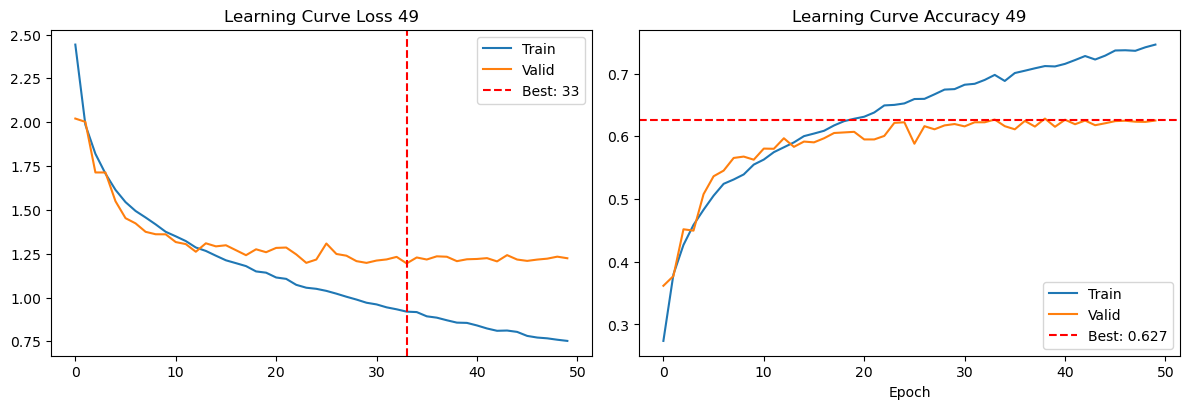

<Figure size 640x480 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

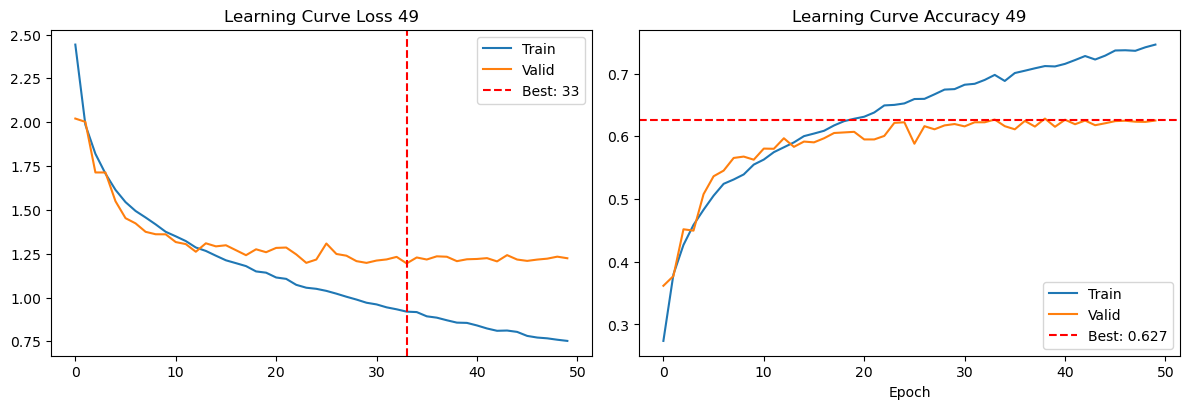

In [59]:
if __name__ == "__main__": 
    best_valid_loss, best_valid_loss_epoch = train(best_valid_loss, best_valid_loss_epoch)
    draw_learning_curve_and_accuracy(losses=(train_losses.get(), valid_losses.get(), best_valid_loss_epoch), 
                                    accs=(train_accs.get(), valid_accs.get()), 
                                    epoch=str(BASE + EPOCHS - 1), 
                                    best_val=valid_accs.get()[best_valid_loss_epoch], 
                                    save=True, 
                                    save_name=f"{model_save_dir}/vis.png")